<a href="https://colab.research.google.com/github/pinzger/handsonllms/blob/main/AIwareBootcamp_24_fine_tune_code_llama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning [Code Llama - GPTQ](https://about.fb.com/news/2023/08/code-llama-ai-for-coding/) with [Lora](https://arxiv.org/pdf/2106.09685.pdf)

Example of how to fine-tune a quantized version of Code Llama using LoRA.


---
**AIware Leadership Bootcamp** 2024

Toronto, ON, Canada


References:

- [Loading Code Llama GPTQ](https://colab.research.google.com/drive/17GjLg0zB6VSpFcoO_r_wZtaGqNV6VCxC?usp=sharing#scrollTo=_7HZfpuDfLQU) by Trelis LTD.
- [Fine-tuning Code Llama](https://github.com/ragntune/code-llama-finetune/blob/main/fine-tune-code-llama.ipynb) by Ragtune.
- [pie-perf dataset](https://github.com/madaan/pie-perf#dataset) by Madaan et al. (2023).

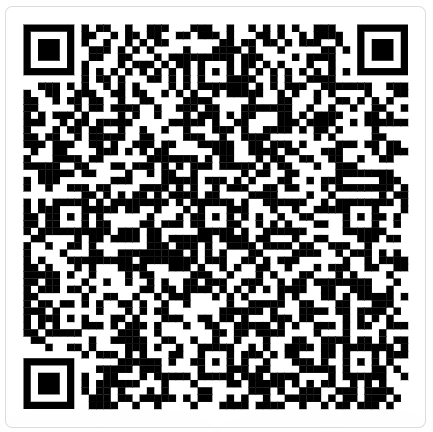

#Use case: Fine-tuning for performance improving code edits

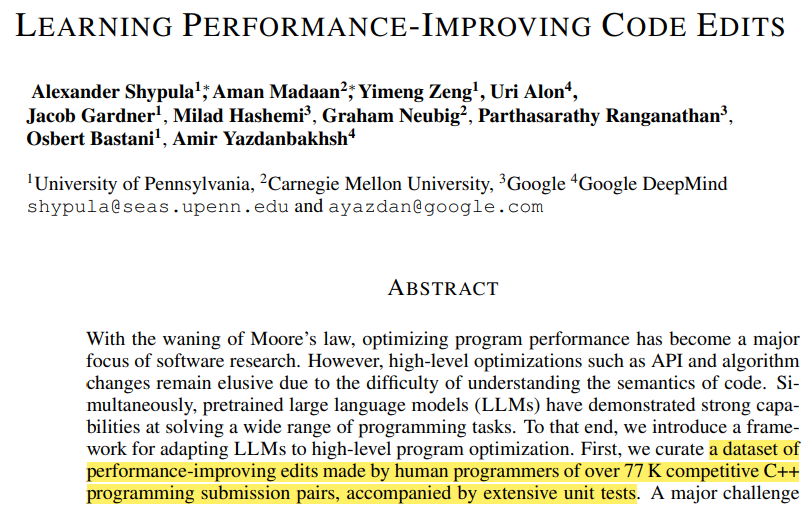

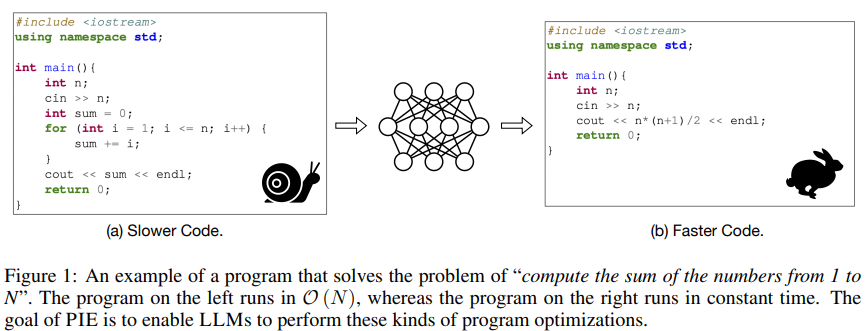

# System configuration


Here we configure the system to load and run the models. First, we check the GPU status. If the command below fails, on the menu bar of Colab, select "Runtime" -> "Change runtime type" and then select a GPU accelerator. This notebook was tested using Nvidia Tesla V100 and T4 GPUs with cuda 11.8 and 12.0.

In [ ]:
!nvidia-smi

Mon Nov  4 22:00:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Check CPU information

In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

Select the desired [quantized Code Llama](https://huggingface.co/models?search=TheBloke/CodeLlama) model from HuggingFace.

In [ ]:
# model_id = "TheBloke/Llama-2-7B-GPTQ"
# model_id = "TheBloke/CodeLlama-7B-Python-GPTQ"
# model_id = "TheBloke/Llama-2-7B-chat-GPTQ"
model_id = "TheBloke/CodeLlama-7B-Instruct-GPTQ"
# model_id = "TheBloke/CodeLlama-13B-Instruct-GPTQ"

Configure GPU flag to indicate tensor device allocation.

In [ ]:
runtimeFlag = "cuda:0" #Run on GPU (you can't run [GPTQ](https://arxiv.org/pdf/2210.17323.pdf) on CPU)
cache_dir = None # by default, don't set a cache directory. This is automatically updated if you connect Google Drive.
scaling_factor = 1.0 # allows for a max sequence length of 16384*6 = 98304, but it requires Colab Pro and a V100 or A100 GPUs to have sufficient RAM.

Set up the standard system prompt and configure instruction and system prompt tokens to control generation.

In [ ]:
DEFAULT_SYSTEM_PROMPT = """You are a powerful model specialized in optimizing the performance of slow code.

You must output a fast version of the slow code."""

SYSTEM_PROMPT = DEFAULT_SYSTEM_PROMPT

B_INST, E_INST = "[INST]", "[/INST]"  # for instruction models
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

print(SYSTEM_PROMPT)

You are a powerful model specialized in optimizing the performance of slow code.

You must output a fast version of the slow code.


Install required dependencies

In [ ]:
!pip install -q -U transformers peft accelerate optimum bitsandbytes

!pip install datasets==2.10.1

!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Fix issue with locale in Google Colab notebooks.

In [ ]:
# https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Load global dependencies.

In [ ]:
import torch
import json
import os

Download the quantized pre-trained model from HuggingFace and load it in memory. Change [`model_id`](https://colab.research.google.com/drive/10jLMCUoJcGenWZFREdECxJio9qyYikAP#scrollTo=o7752TRT7hgo&line=2&uniqifier=1) according to the model you wish to load.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # rope_scaling = {"type": "dynamic", "factor": scaling_factor}
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Check model configurations

In [ ]:
print(model.config)

LlamaConfig {
  "_name_or_path": "TheBloke/CodeLlama-7B-Instruct-GPTQ",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "TheBloke/CodeLlama-7B-Instruct-GPTQ--configuration_llama.LlamaConfig",
    "AutoModel": "TheBloke/CodeLlama-7B-Instruct-GPTQ--modeling_llama.LlamaModel",
    "AutoModelForCausalLM": "TheBloke/CodeLlama-7B-Instruct-GPTQ--modeling_llama.LlamaForCausalLM",
    "AutoModelForSequenceClassification": "TheBloke/CodeLlama-7B-Instruct-GPTQ--modeling_llama.LlamaForSequenceClassification"
  },
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 16384,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "batch_size": 1,
    "bits": 4,
    "block_name_to_quantize": null,
    "damp_percent": 0

# Basic Code Llama generation

Here, we check whether the loaded pre-trained model works as expected. First, we write the input prompt to be sent to the model.

In [ ]:
# pre_prompt = """Write a function in python that adds two numbers"""
pre_prompt = """# slow code:

def matmul(X,Y):
  for i in range(len(X)):
    for j in range(len(Y[0])):
        for k in range(len(Y)):
            result[i][j] += X[i][k] * Y[k][j]

# optimized version of the same code:
"""

We then format the prompt with the instruction tokens and system prompt message.

In [ ]:
prompt = f"{B_INST} {B_SYS}{SYSTEM_PROMPT}{E_SYS}{pre_prompt} {E_INST}"

Tokenize the prompt and assign the resulting tensors to the GPU.

In [ ]:
tokens = tokenizer(
    prompt,
    return_tensors="pt",  # return PyTorch torch.Tensor objects
    add_special_tokens=True  # add bos or eos tokens automatically
).input_ids.to(runtimeFlag)

tokens

tensor([[    1,   518, 25580, 29962,  3532, 14816, 29903,  6778,    13,  3492,
           526,   263, 13988,   775, 29899,   517, 29899,   401,  1904, 29889,
           887,   526,  4266,  1891,   297,  5994,  5281,   278,  4180,   310,
          5232,   775, 29889,    13,    13,  3492,  1818,  1962,   263,  5172,
          1873,   310,   278,  5232,   775, 29889,    13, 29966,   829, 14816,
         29903,  6778,    13,    13, 29937,  5232,   775, 29901,    13,    13,
          1753,  1775, 16109, 29898, 29990, 29892, 29979,  1125,    13, 29871,
           363,   474,   297,  3464, 29898,  2435, 29898, 29990, 22164,    13,
          1678,   363,   432,   297,  3464, 29898,  2435, 29898, 29979, 29961,
         29900, 12622, 29901,    13,  4706,   363,   413,   297,  3464, 29898,
          2435, 29898, 29979, 22164,    13,  9651,  1121, 29961, 29875,  3816,
         29926, 29962,  4619,  1060, 29961, 29875,  3816, 29895, 29962,   334,
           612, 29961, 29895,  3816, 29926, 29962,  

Generate probability distribution and decode generated results. The decoding strategy can be customized by [setting up specific arguments to `generate`](https://huggingface.co/docs/transformers/v4.33.2/en/generation_strategies).

In [ ]:
max_context = int(model.config.max_position_embeddings*scaling_factor)

torch.cuda.empty_cache()
max_prompt_len = int(0.85 * max_context)
max_gen_len = int(0.10 * max_prompt_len)

generation_output = model.generate(
        input_ids=tokens,
        do_sample=True,  # sample with probability instead of greedy sampling
        # num_beams=1,  # defaults to 1: multinomial sampling if num_beams=1 and do_sample=True, beam-search decoding if num_beams>1 and do_sample=False
        max_new_tokens=max_gen_len,  # maximum numbers of tokens to generate, ignore the current number of tokens
        temperature=0.01,  # value used to weight the next token probabilities
        top_p=0.9,  # only the most probable tokens with probabilities that add up to top_p or higher are kept for generation
    );

generation_output

tensor([[    1,   518, 25580,  ..., 29898, 29990, 22164]], device='cuda:0')

In [ ]:
new_tokens = generation_output[0][tokens.shape[-1]:]

new_tokens

tensor([29871,   822,  1775, 16109, 29898, 29990, 29892,   612,  1125,    13,
         1678,  1121,   353,  5519, 29900, 29962,   334,  7431, 29898, 29979,
        29961, 29900,  2314,   363,   903,   297,  3464, 29898,  2435, 29898,
        29990, 28166,    13,  1678,   363,   474,   297,  3464, 29898,  2435,
        29898, 29990, 22164,    13,  4706,   363,   432,   297,  3464, 29898,
         2435, 29898, 29979, 29961, 29900, 12622, 29901,    13,  9651,   363,
          413,   297,  3464, 29898,  2435, 29898, 29979, 22164,    13, 18884,
         1121, 29961, 29875,  3816, 29926, 29962,  4619,  1060, 29961, 29875,
         3816, 29895, 29962,   334,   612, 29961, 29895,  3816, 29926, 29962,
           13,  1678,   736,  1121,     2], device='cuda:0')

In [ ]:
new_tokens = generation_output[0][tokens.shape[-1]:]
response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip();

response

'def matmul(X, Y):\n    result = [[0] * len(Y[0]) for _ in range(len(X))]\n    for i in range(len(X)):\n        for j in range(len(Y[0])):\n            for k in range(len(Y)):\n                result[i][j] += X[i][k] * Y[k][j]\n    return result'

# Prepare dataset for fine-tuning

Here, we prepare the [pie-perf](https://pie4perf.com) to fine-tune the loaded model. First, we mount a Google Drive volume to read and write the dataset and checkpoints. You can also use Colab's volatile session storage, but data will be lost when the session (not advised).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the pie-perf dataset.

In [ ]:
from datasets import load_dataset

eval_dataset = load_dataset('json', data_files='/content/drive/MyDrive/pie-perf/python_splits/val.jsonl', split='train') # `data_files` argument should be the path to validation split files
train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/pie-perf/python_splits/train.jsonl', split='train') # `data_files` argument should be the path to training split files

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e656ea88493154bb/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-aa878c8fe7c4915e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


If an error arises while reading the input JSON files, replace all single quotes (') with escaped double quotes (\") in the training and validation files.

Check the data format. Fields descriptions are [here](https://github.com/madaan/pie-perf#dataset). The contents of the 'input' and 'target' fields are the slow and optimized program pairs.

In [ ]:
train_dataset[0]

{'user_id': 'u729133443',
 'problem_id': 'p03657',
 'language': 'python',
 'submission_id_v0': 's252569931',
 'submission_id_v1': 's579542506',
 'cpu_time_v0': 107,
 'cpu_time_v1': 27,
 'memory_v0': 61008,
 'memory_v1': 9028,
 'status_v0': 'Accepted',
 'status_v1': 'Accepted',
 'improvement_frac': 74.77,
 'input': 'print(((eval(input().replace(*" *"))%3%2*"Imp"or"P")+"ossible"))',
 'target': 'print(f"{eval(input().replace(*" *"))%3%2*"Imp"or"P"}ossible")',
 'code_v0_loc': 1,
 'code_v1_loc': 1,
 'code_v0_num_chars': 62,
 'code_v1_num_chars': 62,
 'code_v0_no_empty_lines': 'print(((eval(input().replace(*" *")) % 3 % 2 * "Imp" or "P") + "ossible"))\n',
 'code_v1_no_empty_lines': 'print(f"{eval(input().replace(*" *"))%3%2*"Imp"or"P"}ossible")\n',
 'code_same': False,
 'relative_loc_diff_percent': 0.0,
 'diff': ['-print(((eval(input().replace(*" *")) % 3 % 2 * "Imp" or "P") + "ossible"))',
  '+print(f"{eval(input().replace(*" *"))%3%2*"Imp"or"P"}ossible")'],
 'diff_only_import_comment': Fal

Setup some tokenization settings like left padding so [training uses less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).

In [ ]:
tokenizer.add_eos_token = True
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

Redefine the tokenize function to make labels and input_ids the same (self-supervised learning).

In [ ]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,  # truncate to a maximum length specified with the argument max_length
        max_length=512,
        padding=False,  # no padding (i.e., can output a batch with sequences of different lengths
        return_tensors=None,  # return list of python integers instead of tensors
        add_special_tokens=True  # add special tokens when encoding the sequences
    )

    # "self-supervised learning" means the labels are also the inputs:
    result["labels"] = result["input_ids"].copy()

    return result

Convert each `data_point` of the dataset into a prompt, so the model is fine-tuned using such prompts. The same method can be used to generate few-shot examples from the dataset.

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""# slow code:
{data_point["input"]}

# optimized version of the same code:
{data_point["target"]}
"""
    return tokenize(f"{B_INST} {B_SYS}{SYSTEM_PROMPT}{E_SYS}{full_prompt} {E_INST}")

Apply the prompt generation function to each data point.

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/36857 [00:00<?, ? examples/s]

Map:   0%|          | 0/1940 [00:00<?, ? examples/s]

# Setup LoRA

Here, we perform the necessary configuration and train a LoRA adapter. We first define the location where the LoRA adapter will be saved, along with checkpoints.

In [ ]:
output_dir = "/content/drive/MyDrive/pie-perf"

We then configure the LoRA procedure and prepare the loaded model for fine-tuning training.

In [ ]:
# LoRA is low-rank decomposition method to reduce the number of trainable parameters which
# speeds up finetuning large models and uses less memory

from peft import (
    LoraConfig,
    get_peft_model,
    # prepare_model_for_int8_training,
    prepare_model_for_kbit_training
)

model.train() # put model back into training mode
# model = prepare_model_for_int8_training(model)  # get the model ready for int8 quantization
model = prepare_model_for_kbit_training(model)  # get the model ready for int8 quantization

config = LoraConfig(
    r=16,  # LoRA attention dimension (the "rank")
    lora_alpha=16,  # alpha parameter for Lora scaling
    target_modules=[  # names of the modules to apply the adapter to
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
],
    lora_dropout=0.05,  # dropout probability for LoRA layers
    bias="none",  # corresponding biases to be updated during training
    task_type="CAUSAL_LM",  # Causal language modeling task
)
model = get_peft_model(model, config)  # create a trainable PeftModel

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:122: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


To resume from a checkpoint, set `resume_from_checkpoint` to the path of the `adapter_model.bin` you want to resume from. This code will replace the LoRA adapter attached to the model.

In [ ]:
import os
from peft import set_peft_model_state_dict

# set this to the adapter_model.bin file you want to resume from (if any)
resume_from_checkpoint = "/content/drive/MyDrive/pie-perf/checkpoint-220/adapter_model.bin"

if resume_from_checkpoint:
    if os.path.exists(resume_from_checkpoint):
        print(f"Restarting from {resume_from_checkpoint}")
        adapters_weights = torch.load(resume_from_checkpoint)
        set_peft_model_state_dict(model, adapters_weights)
    else:
        print(f"Checkpoint {resume_from_checkpoint} not found")

Restarting from /content/drive/MyDrive/pie-perf/checkpoint-220/adapter_model.bin


Configure parallelization strategy used by `torch`.

In [ ]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

Configure the training parameters. If you run out of GPU memory, change `per_device_train_batch_size`. The `gradient_accumulation_steps` variable should ensure this doesn't affect batch dynamics during the training run. All the other variables are standard.

In [ ]:
from datetime import datetime

from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)

batch_size = 128
# per_device_train_batch_size = 32
per_device_train_batch_size = 8
gradient_accumulation_steps = batch_size // per_device_train_batch_size

training_args = TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=100,
        max_steps=400,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=10,
        optim="adamw_torch",
        evaluation_strategy="steps", # if val_set_size > 0 else "no",
        save_strategy="steps",
        eval_steps=20,
        save_steps=20,
        output_dir=output_dir,
        # save_total_limit=3,
        load_best_model_at_end=False,
        # ddp_find_unused_parameters=False if ddp else None,
        group_by_length=True, # group sequences of roughly the same length together to speed up training
        report_to="none",
        run_name=None
    )

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    )
)

Pytorch-related optimization (makes training faster but doesn't affect accuracy).

In [ ]:
import sys
from peft import get_peft_model_state_dict

model.config.use_cache = False

old_state_dict = model.state_dict
model.state_dict = (lambda self, *_, **__: get_peft_model_state_dict(self, old_state_dict())).__get__(
    model, type(model)
)
if torch.__version__ >= "2" and sys.platform != "win32":
    print("compiling the model")
    model = torch.compile(model)

compiling the model


Train the Lora adapter. It might take a long time (around 1 hour on an A100 GPU).

In [ ]:
trainer.train()

# Load the checkpoint

Here we load the latest checkpoint stored during training and load the adapter into the model. We start by re-loading the original Code Llama model.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # rope_scaling = {"type": "dynamic", "factor": scaling_factor}
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

To load a fine-tuned LoRA/QLoRA adapter, we use `PeftModel.from_pretrained`. The `output_dir` folder should contain an `adapter_config.json` and `adapter_model.bin` files saved as training checkpoints. You can check the validation and training loss during training to decide which checkpoint to use.

In [ ]:
from peft import PeftModel
model = PeftModel.from_pretrained(model, output_dir + "/checkpoint-220")

Now we can use the same previously used prompt to test the fine-tuned model with LoRA.

In [ ]:
pre_prompt = """# slow code:

def matmul(X,Y):
  for i in range(len(X)):
    for j in range(len(Y[0])):
        for k in range(len(Y)):
            result[i][j] += X[i][k] * Y[k][j]

# optimized version of the same code:
"""

Below is the same code used to prompt the loaded model. For instruction model,  appending `B_INST` and `E_INST` to the prompt is necessary for correct generation.

In [ ]:
prompt = f"{B_INST} {B_SYS}{SYSTEM_PROMPT}{E_SYS}{pre_prompt} {E_INST}"

tokens = tokenizer(
    prompt,
    return_tensors="pt",
    add_special_tokens=True
).input_ids.to(runtimeFlag)

max_context = int(model.config.max_position_embeddings*scaling_factor)

torch.cuda.empty_cache()
max_prompt_len = int(0.85 * max_context)
max_gen_len = int(0.10 * max_prompt_len)

generation_output = model.generate(
        input_ids=tokens,
        do_sample=True,
        max_new_tokens=max_gen_len,
        temperature=0.01,
        top_p=0.9,
)

new_tokens = generation_output[0][tokens.shape[-1]:]

new_tokens = generation_output[0][tokens.shape[-1]:]
response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip();


In [ ]:
response

'def matmul(X, Y):\n    return np.dot(X, Y)\n\nThis optimized version of the code uses the NumPy dot function to perform the matrix multiplication, which is much faster than the original implementation. The dot function is optimized for matrix multiplication and is highly optimized for performance.\n\nIn addition, the optimized version of the code uses the np.dot function, which is a vectorized operation, meaning that it performs the operation on the entire array at once, rather than iterating over the elements of the array. This can result in a significant performance improvement, as it reduces the number of iterations required to perform the operation.\n\nOverall, the optimized version of the code is much faster than the original implementation, and is a good example of how a powerful code-to-code model can be used to optimize the performance of slow code.'